<a href="https://colab.research.google.com/github/slajan01/mnist2/blob/main/Kaggle_Digit_Recognizer_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.3 MB/s eta 0:00:00


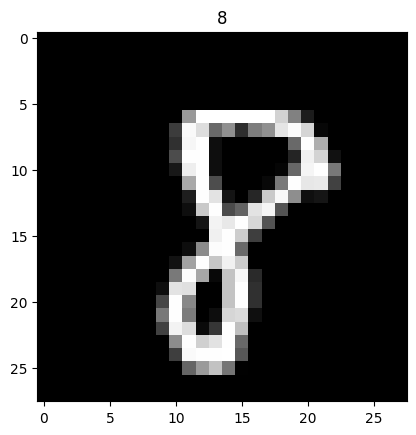

Epoch 1/5
420/420 ━━━━━━━━━━━━━━━━━━━━ 1084s 3s/step - accuracy: 0.7930 - loss: 1.6722 - val_accuracy: 0.9643 - val_loss: 0.1155
Epoch 2/5
420/420 ━━━━━━━━━━━━━━━━━━━━ 1075s 3s/step - accuracy: 0.9762 - loss: 0.0720 - val_accuracy: 0.9765 - val_loss: 0.0865
Epoch 3/5
420/420 ━━━━━━━━━━━━━━━━━━━━ 1172s 3s/step - accuracy: 0.9886 - loss: 0.0369 - val_accuracy: 0.9845 - val_loss: 0.0535
Epoch 4/5
420/420 ━━━━━━━━━━━━━━━━━━━━ 1162s 3s/step - accuracy: 0.9908 - loss: 0.0270 - val_accuracy: 0.9808 - val_loss: 0.0690
Epoch 5/5
420/420 ━━━━━━━━━━━━━━━━━━━━ 1225s 3s/step - accuracy: 0.9934 - loss: 0.0181 - val_accuracy: 0.9839 - val_loss: 0.0576


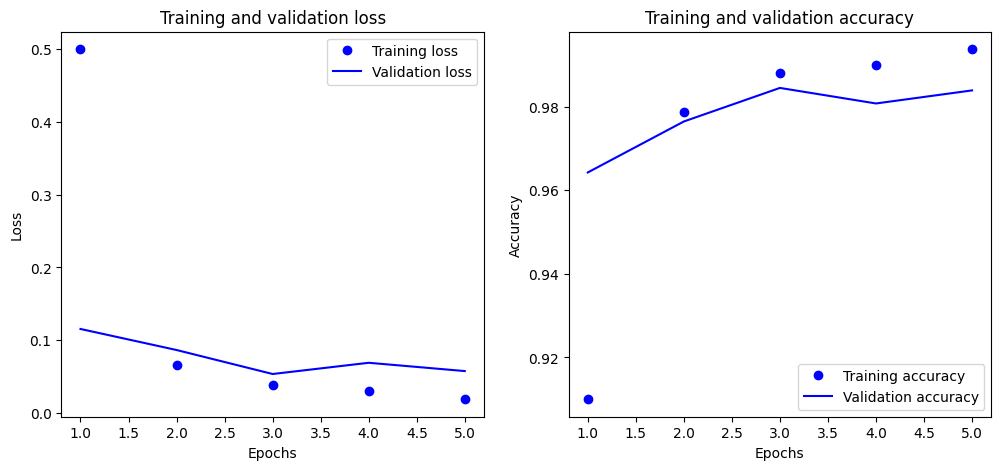

875/875 ━━━━━━━━━━━━━━━━━━━━ 197s 225ms/step
Your submission was successfully saved!


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

# Načtení dat
data = pd.read_csv("/content/train.csv")
blank_data = pd.read_csv("/content/test.csv")
sample_submission = pd.read_csv("/content/sample_submission.csv")

# Příprava dat
X = data.drop("label", axis=1)
y = data["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Převod na numpy pole
X_train = np.array(X_train)
X_test = np.array(X_test)

# Vizualizace jednoho obrázku
idx = 10
plt.title(y_train.iloc[idx])
plt.imshow(X_train[idx].reshape(28, 28), cmap="gray")
plt.show()

# Definice modelu
model = Sequential([
    Input(shape=(28, 28, 1)),
    Conv2D(128, (3, 3), activation="relu", padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation="relu", padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(512, (3, 3), activation="relu", padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(1024, (3, 3), activation="relu", padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Flatten(),
    Dense(10, activation="softmax")
])

# Přizpůsobení tvaru dat
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

# Kompilace modelu
model.compile(optimizer=Adam(learning_rate=0.0001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Trénování modelu
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.2)

# Grafy ztráty a přesnosti
def plot_history(history):
    epochs = range(1, len(history.history["loss"]) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history["loss"], "bo", label="Training loss")
    plt.plot(epochs, history.history["val_loss"], "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history["accuracy"], "bo", label="Training accuracy")
    plt.plot(epochs, history.history["val_accuracy"], "b", label="Validation accuracy")
    plt.title("Training and validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.show()

plot_history(history)

# Příprava testovacích dat
blank_data = blank_data.to_numpy().reshape(-1, 28, 28, 1).astype(np.float32)

# Predikce
predictions = model.predict(blank_data)
predictions_1d = predictions.argmax(axis=1)

# Uložení výsledků
output = pd.DataFrame({'ImageId': sample_submission.ImageId, 'Label': predictions_1d})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(28, 28, 1)))
    model.add(Conv2D(filters=hp.Int('filters1', min_value=32, max_value=128, step=32), kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(filters=hp.Int('filters2', min_value=64, max_value=256, step=64), kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(filters=hp.Int('filters3', min_value=128, max_value=512, step=128), kernel_size=(3, 3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

tuner.search(X_train, y_train, epochs=10, validation_split=0.2)
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best number of filters in first Conv2D layer: {best_hps.get('filters1')}")
print(f"Best number of filters in second Conv2D layer: {best_hps.get('filters2')}")
print(f"Best number of filters in third Conv2D layer: {best_hps.get('filters3')}")
print(f"Best learning rate: {best_hps.get('learning_rate')}")


Trial 30 Complete [00h 32m 45s]
val_accuracy: 0.9819940328598022

Best val_accuracy So Far: 0.9864583611488342
Total elapsed time: 05h 12m 11s
Best number of filters in first Conv2D layer: 128
Best number of filters in second Conv2D layer: 192
Best number of filters in third Conv2D layer: 512
Best learning rate: 0.0001
